In [1]:
!pip install qujax

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 32.3 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.2/79.2 MB 12.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 43.4 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 2.2 MB/s eta 0:00:00


In [2]:
from jax import numpy as jnp, random, vmap, grad, value_and_grad, jit
import matplotlib.pyplot as plt
import qujax
import jax
import numpy as np
import matplotlib.pyplot as plt
import time
import pickle

In [3]:
save_folder ='bi_gaussian_noise/'

In [7]:
## Plot function 
def plot_histogram_and_line(data, final_st):
    fig, ax = plt.subplots()
    
    # Plot histogram for data
    ax.hist(data, bins=50, density=True, alpha=0.5, label="Data")
    
    # Plot line for Final Parameter
    ax.plot(final_st, label="Final Parameter", color='orange')
    
    # Plot line for Averaged over parameters
   # ax.plot(data_avg, label="Averaged over parameters", linestyle='--', color='orange')
    
    # Adjust plot settings
    ax.set_xlim(data.min(), data.max())
    ax.set_ylabel("Probability")
    ax.set_xlabel("Data $\mu$m")
    ax.legend()
    
    return fig

In [4]:
def expected_kernel(kernel, data1, weights1, data2, weights2):
    def row_eval(data1_single):
        return (vmap(kernel, in_axes=(None, 0))(data1_single, data2) * weights2).sum()

    return (vmap(row_eval)(data1) * weights1).sum()


def mmd(kernel, data1, weights1, data2, weights2):
    return (
        expected_kernel(kernel, data1, weights1, data1, weights1)
        - 2 * expected_kernel(kernel, data1, weights1, data2, weights2)
        + expected_kernel(kernel, data2, weights2, data2, weights2)
    )

def get_circuit(n_qubits, depth):
    n_params = 2 * n_qubits * (depth + 1)

    gates = ["H"] * n_qubits + ["Rx"] * n_qubits + ["Ry"] * n_qubits
    qubit_inds = [[i] for i in range(n_qubits)] * 3
    param_inds = [[]] * n_qubits + [[i] for i in range(n_qubits * 2)]

    k = 2 * n_qubits

    for _ in range(depth):
        for i in range(0, n_qubits - 1):
            gates.append("CZ")
            qubit_inds.append([i, i + 1])
            param_inds.append([])
        for i in range(n_qubits):
            gates.append("Rx")
            qubit_inds.append([i])
            param_inds.append([k])
            k += 1
        for i in range(n_qubits):
            gates.append("Ry")
            qubit_inds.append([i])
            param_inds.append([k])
            k += 1
    return gates, qubit_inds, param_inds, n_params


def gaussian_kernel(s1, s2):
    return jnp.exp(-jnp.square(s1 - s2) / bandwidth_sq)


def param_to_mmd(param):
    st = param_to_st(param)
    probs = jnp.square(jnp.abs(st.flatten()))
    return mmd(gaussian_kernel, jnp.arange(st.size), probs, data, data_probs)

def compute_av_probs(params, burn_in):
    probs = vmap(lambda p: jnp.square(jnp.abs(param_to_st(p).flatten())))(params[burn_in:])
    return probs.mean(axis=0)

In [5]:
## New method

def G(p):
  return mu_inv * (p.T @ M_inv @ p - N_d * kBT)

def A_step(q,p,xi,h):
  q = q + h * M_inv @ p
  return q,p,xi

def B_step(q,p,xi,h,force):
  p = p + h * (force(q) + sigma * np.sqrt(M) @ np.random.randn(p.shape[0]))
  return q,p,xi

def O_step(q,p,xi,h):
  term1 = np.exp(-xi*h) * p
  term2 = sigma_a * np.sqrt((1 - np.exp(-2 * xi * h)) / (2 * xi)) * np.random.randn(p.shape[0])
  p = term1 + term2
  return q,p,xi

def D_step(q,p,xi,h):
  xi = xi + h * G(p)
  return q,p,xi

def ld_BADODAB(q,p,xi,h,force):

    q, p, xi = np.copy(q), np.copy(p), np.copy(xi)
    q, p, xi = B_step(q,p,xi,h/2,force)
    q, p, xi = A_step(q,p,xi,h/2)
    q, p, xi = D_step(q,p,xi,h/2)
    q, p, xi = O_step(q,p,xi,h)
    q, p, xi = D_step(q,p,xi,h/2)
    q, p, xi = A_step(q,p,xi,h/2)
    q, p, xi = B_step(q,p,xi,h/2,force)

    return q, p, xi

def run_simulation(q0, p0, xi0, Nsteps, h, step_function, force):
    import time
    bar_length = 30
    
    q_traj = [q0]
    p_traj = [p0]
    xi_traj = [xi0]
    cost_vals = []

    q = q0
    p = p0
    xi = xi0
    
    start_time = time.time()  # Record the start time

    for n in range(Nsteps):
        cost_val, cost_grad = param_to_mmd_and_grad(q_traj[n - 1])
        noise = random.normal(train_keys[n - 1], shape=cost_grad.shape, dtype=jnp.float32)
        cost_grad = cost_grad + noise
        
        q,p,xi = step_function(q, p, xi, h, force)
        cost_vals.append(cost_val)

        q_traj += [q]
        p_traj += [p]
        xi_traj += [xi]
        
        progress = (n+1) / Nsteps
        filled_length = int(bar_length * progress)
        bar = '█' * filled_length + '-' * (bar_length - filled_length)
        
        elapsed_time = time.time() - start_time  # Compute the elapsed time
        remaining_time = (elapsed_time / (n + 1)) * (Nsteps - n - 1)  # Estimate the remaining time

        
        print(f'\rProgress: |{bar}| {progress:.2%} | Iteration: {n+1}/{Nsteps} | Cost: {cost_val:.6f} | Elapsed Time: {elapsed_time:.2f}s | Estimated Remaining Time: {remaining_time:.2f}s', end='')    
    print()  # Move to the next line after the progress bar
    
    total_run_time = time.time() - start_time  # Compute the total run time
    
    return q_traj, p_traj, xi_traj, cost_vals, total_run_time

running sim
Progress: |██████████████████████████████| 100.00% | Iteration: 10000/10000 | Cost: 0.249506 | Elapsed Time: 733.33s | Estimated Remaining Time: 0.00s


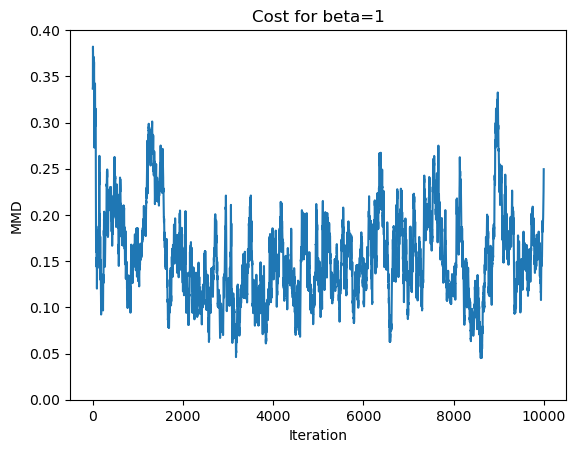

running sim
Progress: |██████████████████████████████| 100.00% | Iteration: 10000/10000 | Cost: 0.019869 | Elapsed Time: 741.90s | Estimated Remaining Time: 0.00s


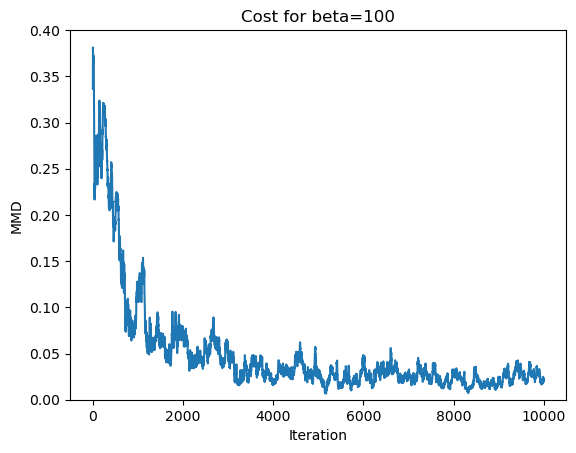

running sim
Progress: |██████████████████████████████| 100.00% | Iteration: 10000/10000 | Cost: 0.031205 | Elapsed Time: 748.12s | Estimated Remaining Time: 0.00s


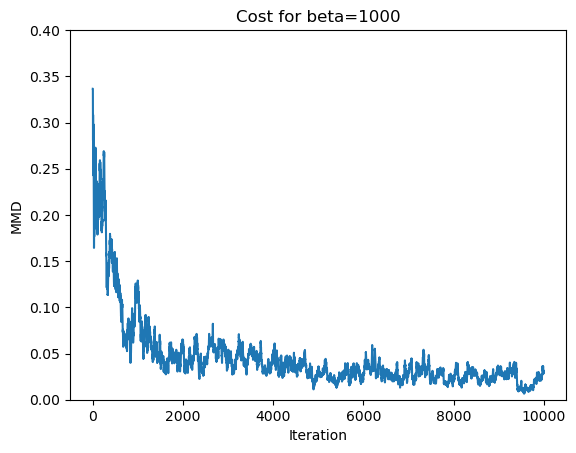

running sim
Progress: |██████████████████████████████| 100.00% | Iteration: 10000/10000 | Cost: 0.029753 | Elapsed Time: 755.42s | Estimated Remaining Time: 0.00s


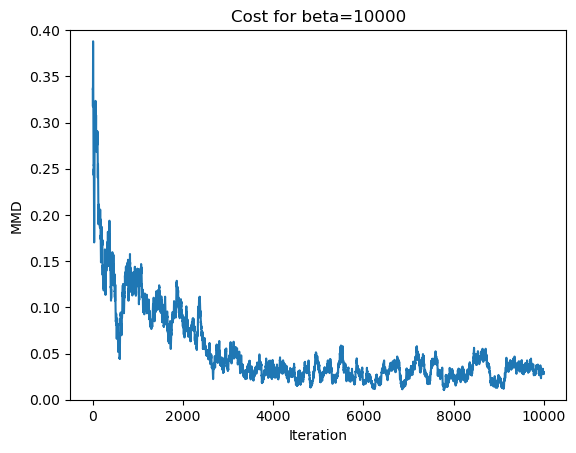

NameError: name 'plot_histogram_and_line' is not defined

In [6]:
with open(f'bi_gaussian/gen_data.pkl', 'rb') as file:
    data = pickle.load(file)

betas = [1,100,1000,10000]  # Set the range of betas for the sim 
number_of_data_points = 5000
n_qubits = 8 # For the 
circuit_depth = 3
init_rad = 0.001 / jnp.pi
get_stepsize = lambda step: (step + 10) ** (-1 / 3)
n_steps = 10000
random_key = random.PRNGKey(0)
init_key, train_key = random.split(random_key)

## These take awhile for large data sets
# computes pairwise 
dist_mat = vmap(lambda a: vmap(lambda b: (a - b) ** 2)(data))(data)
# get bandwidth
bandwidth_sq = jnp.median(dist_mat) / 2

# allocate memory 
results_beta = {} 

for beta in betas:

    gates, qubit_inds, param_inds, n_params = get_circuit(n_qubits, circuit_depth)
    M, M_inv, mu_inv, N_d, kBT, sigma, sigma_a = jnp.eye(n_params), jnp.eye(n_params), 1., 1., 1/beta, 1., 1.
    param_to_st = qujax.get_params_to_statetensor_func(gates, qubit_inds, param_inds)
    data_probs = jnp.ones(len(data)) / len(data)
    param_to_mmd_and_grad = jit(value_and_grad(param_to_mmd))
    
    init_param = random.uniform(
    init_key, shape=(n_params,), minval=-init_rad, maxval=init_rad
    )
  
    params = jnp.zeros((n_steps, n_params))
    params = params.at[0].set(init_param)
    
    cost_vals = jnp.zeros(n_steps - 1)

    train_keys = random.split(train_key, n_steps - 1)
    print('running sim')

    # run the sim
    params, p_traj, xi_traj, cost_vals, total_run_time = run_simulation(
        params[0],
        np.random.randn(n_params),
        0.0,
        n_steps,
        0.1,
        ld_BADODAB,
        lambda q: -param_to_mmd_and_grad(q)[1])

    plt.plot(cost_vals)
    plt.title(f'Cost for beta={beta}')
    plt.xlabel("Iteration")
    plt.ylabel("MMD")
    plt.ylim(0, 0.4)
    plt.show() 

    final_params = params[-1]
    final_st = param_to_st(final_params)

    results_beta[str(beta)] = (jnp.square(jnp.abs(final_st.flatten())), cost_vals, total_run_time, params)
    
with open(f'{save_folder}/new_results_beta.pkl', 'wb') as file:
    pickle.dump(results_beta, file)
    
# Iterate over the results_beta dictionary and plot each set of results
for beta, (final_st,cost,time,_ ) in results_beta.items():
    fig = plot_histogram_and_line(data, final_st)
    plt.title(f"Results for Beta = {beta}")
    plt.show()

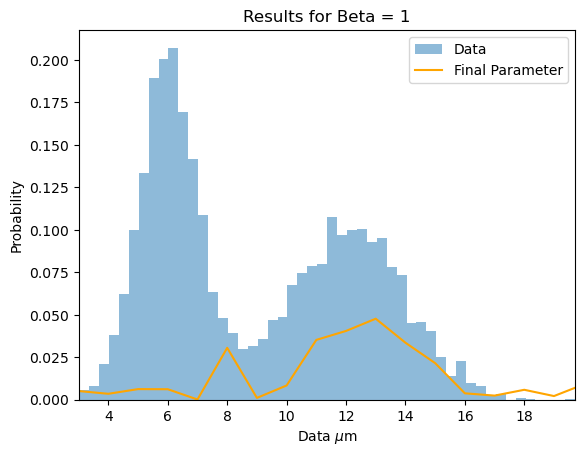

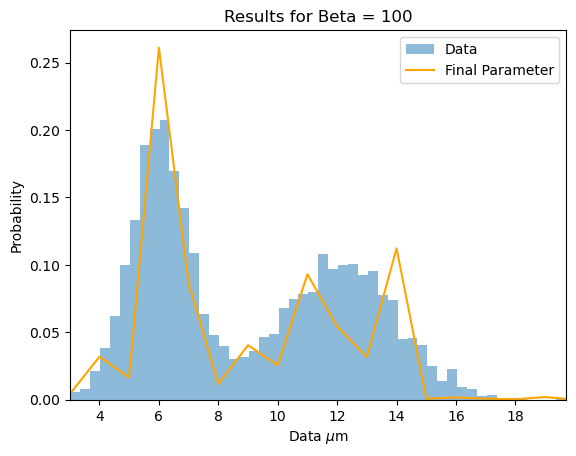

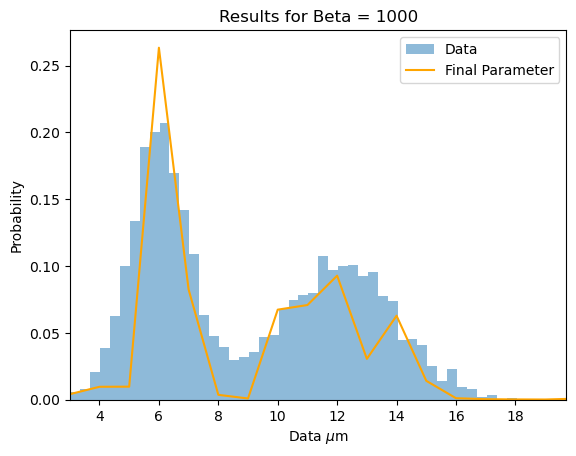

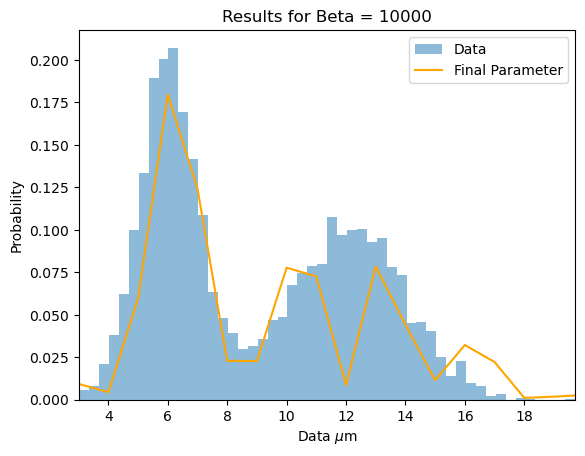

In [8]:
    
# Iterate over the results_beta dictionary and plot each set of results
for beta, (final_st,cost,time,_ ) in results_beta.items():
    fig = plot_histogram_and_line(data, final_st)
    plt.title(f"Results for Beta = {beta}")
    plt.show()

running sim
Progress: |██████████████████████████████| 100.00% | Iteration: 10000/10000 | Cost: 0.044149 | Elapsed Time: 693.28s | Estimated Remaining Time: 0.00s


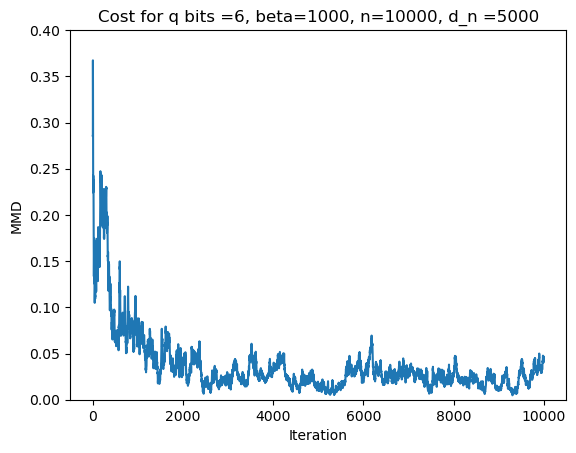

running sim
Progress: |██████████████████████████████| 100.00% | Iteration: 10000/10000 | Cost: 0.017430 | Elapsed Time: 719.80s | Estimated Remaining Time: 0.00s


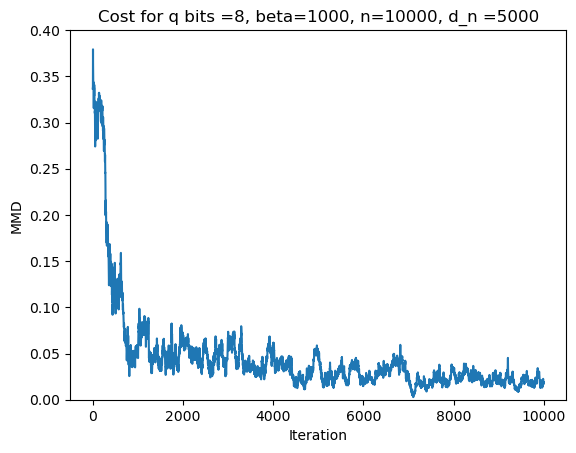

running sim
Progress: |██████████████████████████████| 100.00% | Iteration: 10000/10000 | Cost: 0.042386 | Elapsed Time: 863.47s | Estimated Remaining Time: 0.00s


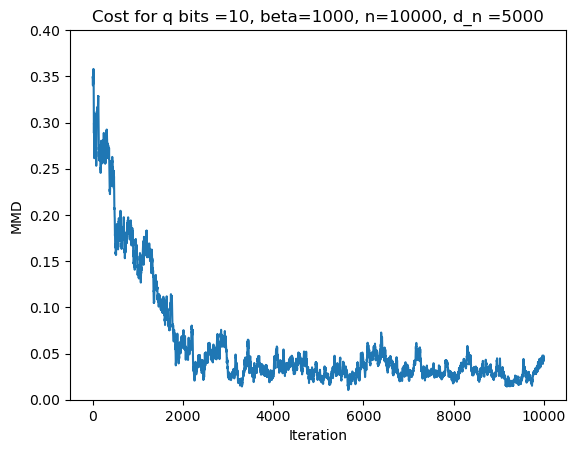

running sim
Progress: |██████████████████████████████| 100.00% | Iteration: 10000/10000 | Cost: 0.034280 | Elapsed Time: 4391.83s | Estimated Remaining Time: 0.00ss


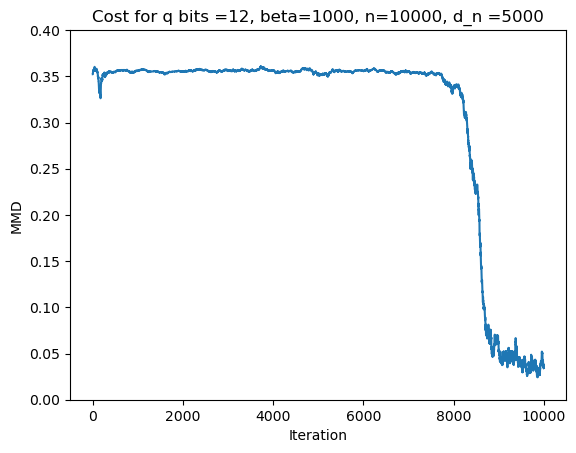

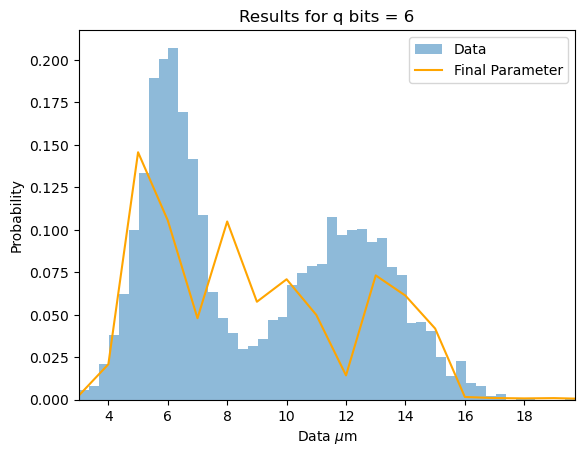

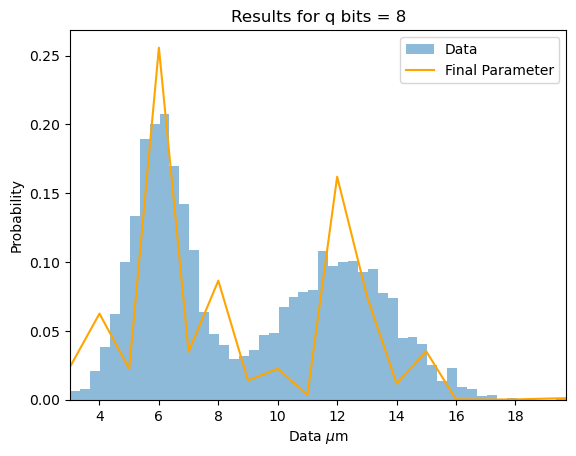

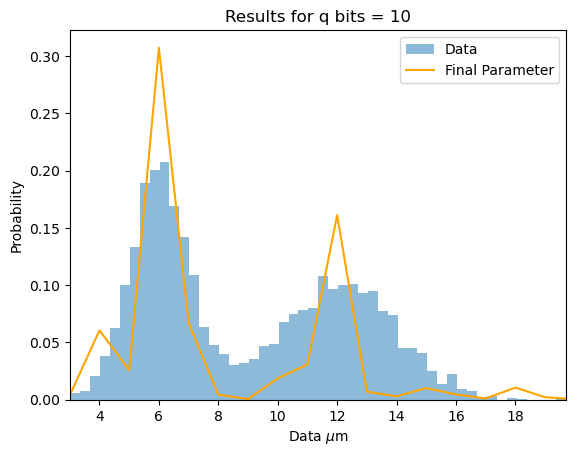

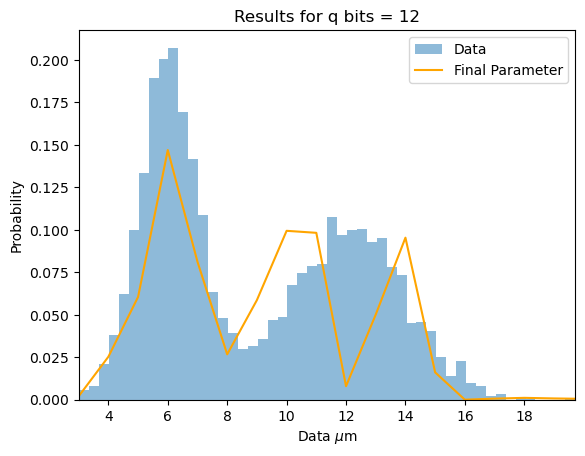

In [16]:
n_qubits_list = [6,8,10,12] # For the 


beta = 1000  # Set the range of betas for the sim 
number_of_data_points = 5000
circuit_depth = 3
init_rad = 0.001 / jnp.pi
get_stepsize = lambda step: (step + 10) ** (-1 / 3)
n_steps = 10000
random_key = random.PRNGKey(0)
init_key, train_key = random.split(random_key)


with open(f'{save_folder}/gen_data.pkl', 'rb') as file:
    data = pickle.load(file)

## These take awhile for large data sets
# computes pairwise 
dist_mat = vmap(lambda a: vmap(lambda b: (a - b) ** 2)(data))(data)
# get bandwidth
bandwidth_sq = jnp.median(dist_mat) / 2

# allocate memory 
results_qubits = {} 

for n_qubits in n_qubits_list:

    gates, qubit_inds, param_inds, n_params = get_circuit(n_qubits, circuit_depth)
    M, M_inv, mu_inv, N_d, kBT, sigma, sigma_a = jnp.eye(n_params), jnp.eye(n_params), 1., 1., 1/beta, 1., 1.
    param_to_st = qujax.get_params_to_statetensor_func(gates, qubit_inds, param_inds)
    data_probs = jnp.ones(len(data)) / len(data)
    param_to_mmd_and_grad = jit(value_and_grad(param_to_mmd))
    init_param = random.uniform(
    init_key, shape=(n_params,), minval=-init_rad, maxval=init_rad
    )
  

    params = jnp.zeros((n_steps, n_params))
    params = params.at[0].set(init_param)
    
    cost_vals = jnp.zeros(n_steps - 1)

    train_keys = random.split(train_key, n_steps - 1)
    print('running sim')

    # run the sim
    params, p_traj, xi_traj, cost_vals, total_run_time = run_simulation(
        params[0],
        np.random.randn(n_params),
        0.0,
        n_steps,
        0.1,
        ld_BADODAB,
        lambda q: -param_to_mmd_and_grad(q)[1])

    plt.plot(cost_vals)
    plt.title(f'Cost for q bits ={n_qubits}, beta={beta}, n={n_steps}, d_n ={number_of_data_points}')
    plt.xlabel("Iteration")
    plt.ylabel("MMD")
    plt.ylim(0, 0.4)
    plt.show() 

    final_params = params[-1]
    final_st = param_to_st(final_params)

    results_qubits[str(n_qubits)] = (jnp.square(jnp.abs(final_st.flatten())), cost_vals,total_run_time, params) 

# Save results_beta to a file
with open(f'{save_folder}/new_results_qubits.pkl', 'wb') as file:
    pickle.dump(results_qubits, file)
    
# Iterate over the results_beta dictionary and plot each set of results
for qbits, (final_st, cost,time,_) in results_qubits.items():
    fig = plot_histogram_and_line(data, final_st)
    plt.title(f"Results for q bits = {qbits}")
    plt.show()  


running sim
Progress: |██████████████████████████████| 100.00% | Iteration: 10000/10000 | Cost: 0.045573 | Elapsed Time: 697.88s | Estimated Remaining Time: 0.00s


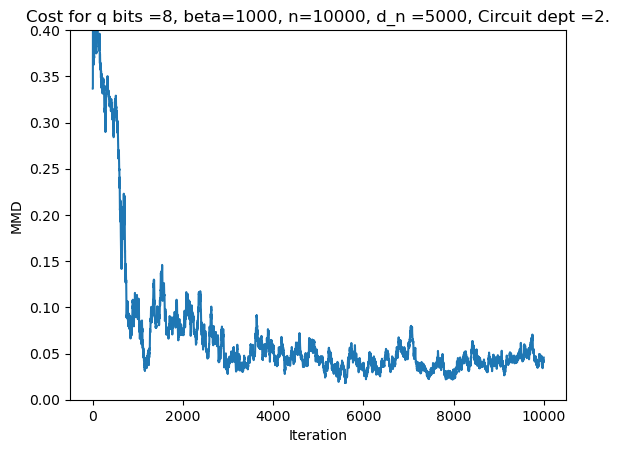

running sim
Progress: |██████████████████████████████| 100.00% | Iteration: 10000/10000 | Cost: 0.023268 | Elapsed Time: 700.79s | Estimated Remaining Time: 0.00s


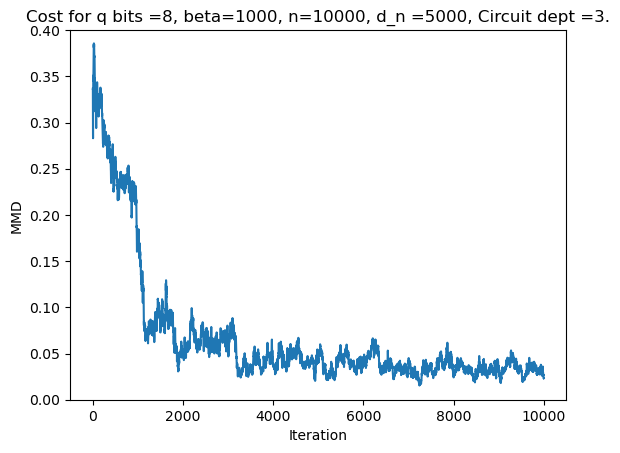

running sim
Progress: |██████████████████████████████| 100.00% | Iteration: 10000/10000 | Cost: 0.023977 | Elapsed Time: 711.29s | Estimated Remaining Time: 0.00s


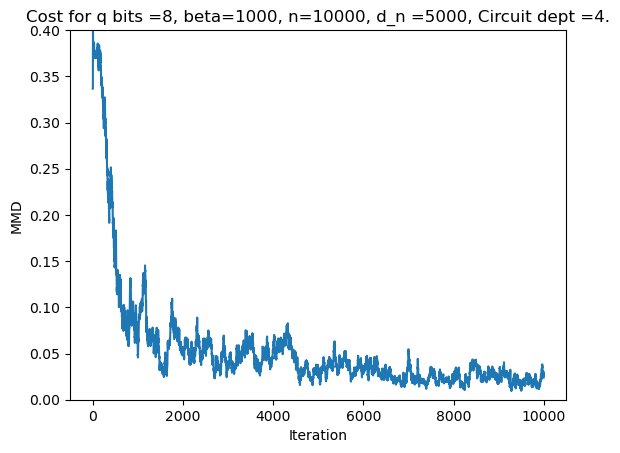

running sim
Progress: |█████████████████-------------| 57.08% | Iteration: 5708/10000 | Cost: 0.039310 | Elapsed Time: 1105.54s | Estimated Remaining Time: 831.29s

In [ ]:
circuit_depth_list = [2,3,4,5]


beta = 1000  # Set the range of betas for the sim 
number_of_data_points = 5000
n_qubits  = 8 # For the 
init_rad = 0.001 / jnp.pi
get_stepsize = lambda step: (step + 10) ** (-1 / 3)
n_steps = 10000
random_key = random.PRNGKey(0)
init_key, train_key = random.split(random_key)
# Generate random numbers following a Gaussian distribution
key = random.PRNGKey(0)  # Initialize a random key

with open(f'{save_folder}/gen_data.pkl', 'rb') as file:
    data = pickle.load(file)

## These take awhile for large data sets
# computes pairwise 
dist_mat = vmap(lambda a: vmap(lambda b: (a - b) ** 2)(data))(data)
# get bandwidth
bandwidth_sq = jnp.median(dist_mat) / 2

# allocate memory 
results_circuit_depth = {} 

for circuit_depth in circuit_depth_list:

    gates, qubit_inds, param_inds, n_params = get_circuit(n_qubits, circuit_depth)
    M, M_inv, mu_inv, N_d, kBT, sigma, sigma_a = jnp.eye(n_params), jnp.eye(n_params), 1., 1., 1/beta, 1., 1.
    param_to_st = qujax.get_params_to_statetensor_func(gates, qubit_inds, param_inds)
   

    data_probs = jnp.ones(len(data)) / len(data)
    param_to_mmd_and_grad = jit(value_and_grad(param_to_mmd))
    
    init_param = random.uniform(
    init_key, shape=(n_params,), minval=-init_rad, maxval=init_rad
    )
  

    params = jnp.zeros((n_steps, n_params))
    params = params.at[0].set(init_param)
    
    cost_vals = jnp.zeros(n_steps - 1)

    train_keys = random.split(train_key, n_steps - 1)
    print('running sim')

    # run the sim
    params, p_traj, xi_traj, cost_vals, total_run_time = run_simulation(
        params[0],
        np.random.randn(n_params),
        0.0,
        n_steps,
        0.1,
        ld_BADODAB,
        lambda q: -param_to_mmd_and_grad(q)[1])

    plt.plot(cost_vals)
    plt.title(f'Cost for q bits ={n_qubits}, beta={beta}, n={n_steps}, d_n ={number_of_data_points}, Circuit dept ={circuit_depth}.')
    plt.xlabel("Iteration")
    plt.ylabel("MMD")
    plt.ylim(0, 0.4)
    plt.show() 

    final_params = params[-1]
    final_st = param_to_st(final_params)

    results_circuit_depth[str(circuit_depth)] = (jnp.square(jnp.abs(final_st.flatten())), cost_vals,total_run_time,params) 

# Save results_beta to a file
with open(f'{save_folder}/new_results_circuit_depth.pkl', 'wb') as file:
    pickle.dump(circuit_depth, file)

    
# Iterate over the results_beta dictionary and plot each set of results
for cdepth, (final_st, cost,time,_) in results_circuit_depth.items():
    fig = plot_histogram_and_line(data, final_st)
    plt.title(f"Results for c depth = {cdepth}")
    plt.show()  

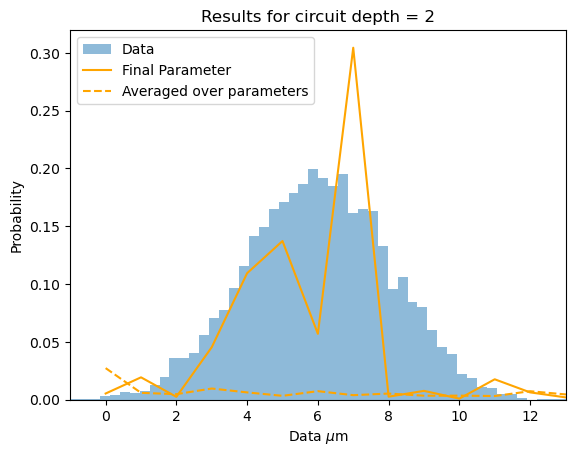

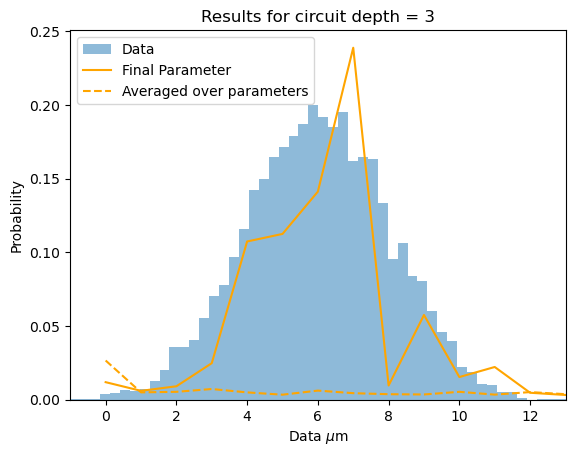

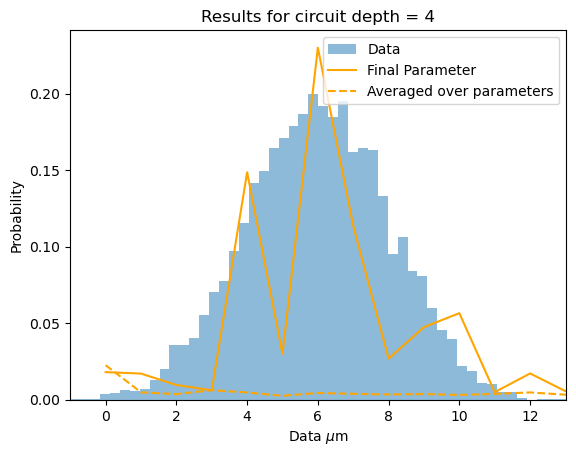

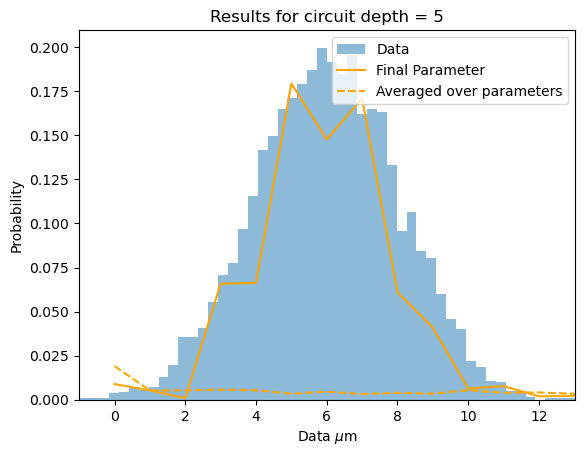

In [12]:
# Iterate over the results_beta dictionary and plot each set of results
for circuit_depth, (final_st, av_probs, cost,time, _) in results_circuit_depth.items():
    fig = plot_histogram_and_line(data, av_probs, final_st)
    plt.title(f"Results for circuit depth = {circuit_depth}")
    plt.show()

running sim
Progress: |██████████████████████████████| 100.00% | Iteration: 10000/10000 | Cost: 0.024890 | Elapsed Time: 710.37s | Estimated Remaining Time: 0.00s


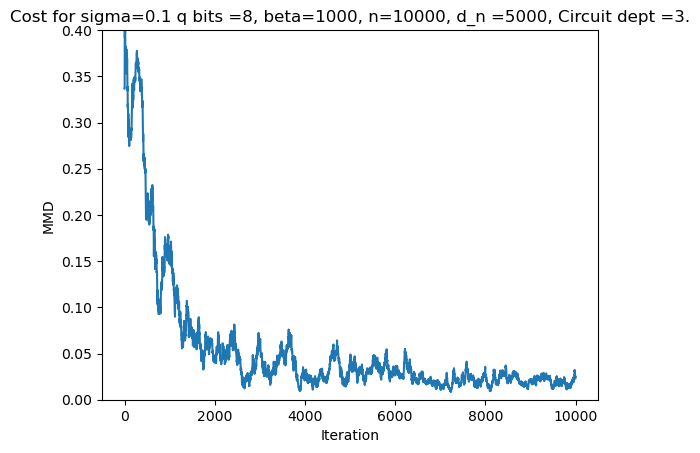

running sim
Progress: |██████████████████████████████| 100.00% | Iteration: 10000/10000 | Cost: 0.030930 | Elapsed Time: 698.88s | Estimated Remaining Time: 0.00s


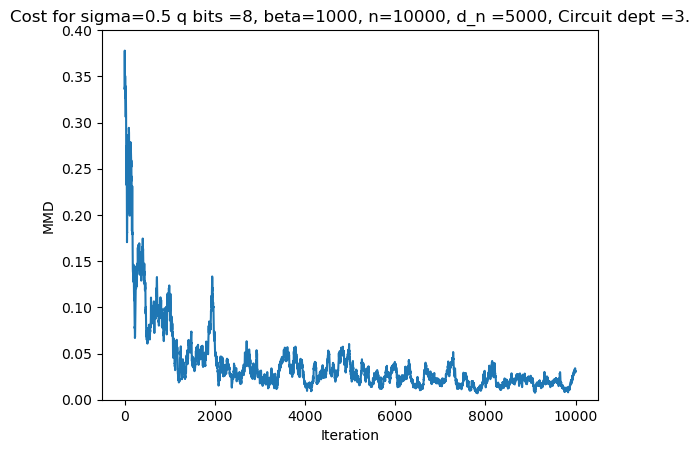

running sim
Progress: |██████████████████████████████| 100.00% | Iteration: 10000/10000 | Cost: 0.033023 | Elapsed Time: 707.20s | Estimated Remaining Time: 0.00s


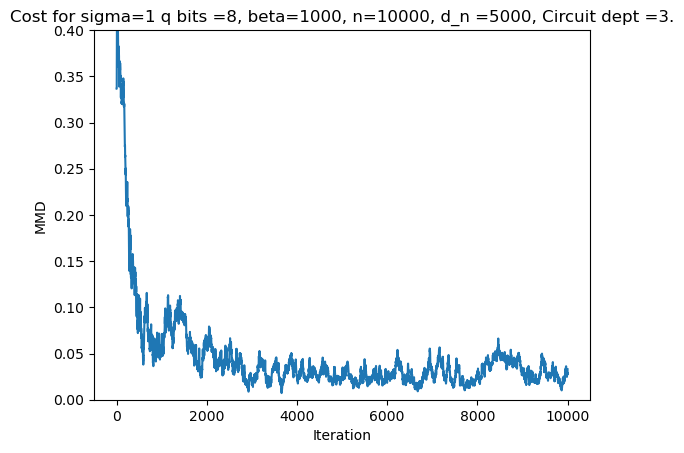

running sim
Progress: |██████████████████████████████| 100.00% | Iteration: 10000/10000 | Cost: 0.056551 | Elapsed Time: 699.64s | Estimated Remaining Time: 0.00s


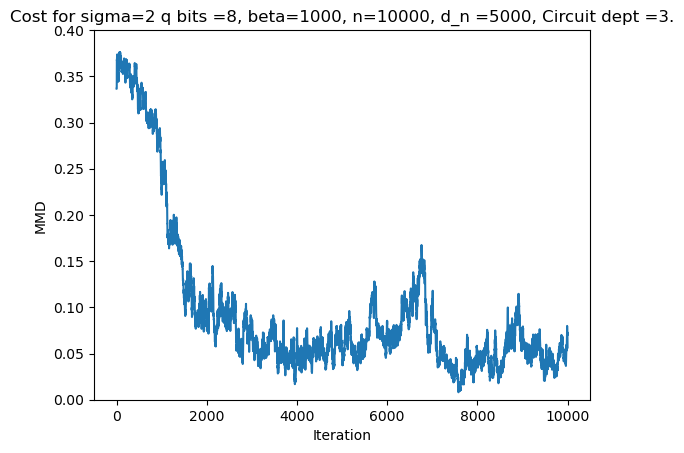

running sim
Progress: |██████████████████████████████| 100.00% | Iteration: 10000/10000 | Cost: 0.341523 | Elapsed Time: 707.12s | Estimated Remaining Time: 0.00s


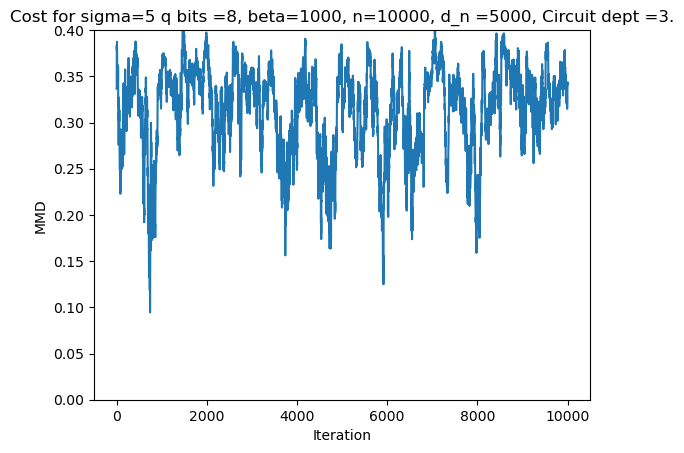

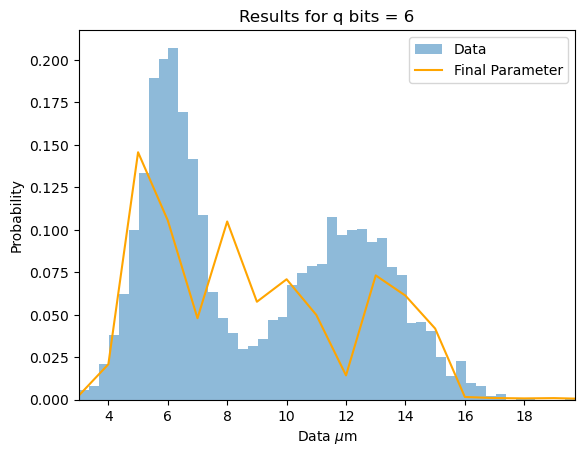

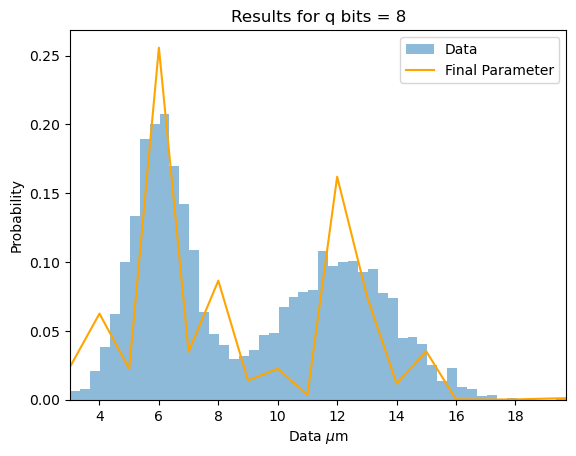

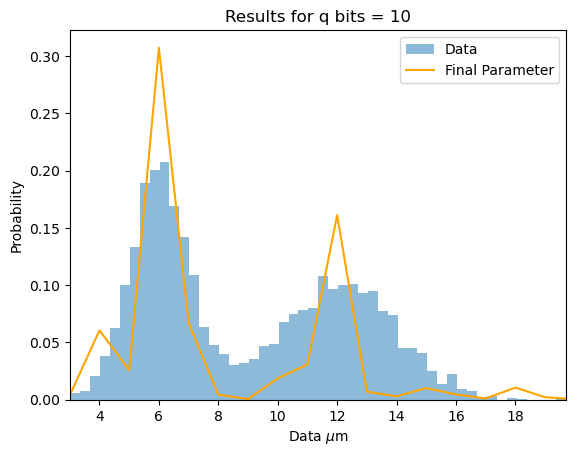

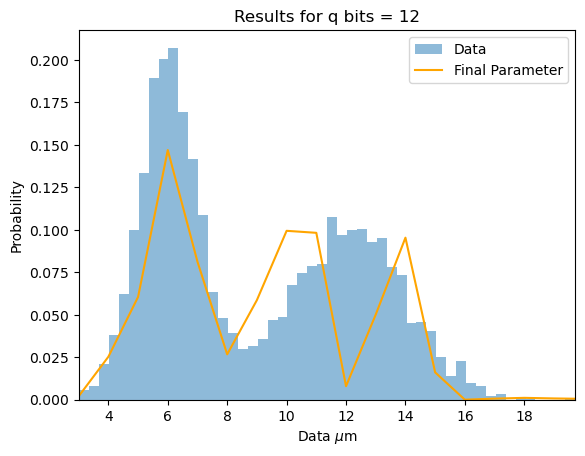

In [25]:
sigma_list = [0.1,0.5,1,2,5]


beta = 1000  # Set the range of betas for the sim 
number_of_data_points = 5000
n_qubits  = 8 # For the 
circuit_depth = 3
init_rad = 0.001 / jnp.pi
get_stepsize = lambda step: (step + 10) ** (-1 / 3)
n_steps = 10000
random_key = random.PRNGKey(0)

init_key, train_key = random.split(random_key)
# Generate random numbers following a Gaussian distribution
key = random.PRNGKey(0)  # Initialize a random key

## These take awhile for large data sets
# computes pairwise 
dist_mat = vmap(lambda a: vmap(lambda b: (a - b) ** 2)(data))(data)
# get bandwidth
bandwidth_sq = jnp.median(dist_mat) / 2

# allocate memory 
results_sigmas = {} 

for sigma in sigma_list:

    gates, qubit_inds, param_inds, n_params = get_circuit(n_qubits, circuit_depth)
    M, M_inv, mu_inv, N_d, kBT, sigma_a = jnp.eye(n_params), jnp.eye(n_params), 1., 1., 1/beta, 1.
    param_to_st = qujax.get_params_to_statetensor_func(gates, qubit_inds, param_inds)
    data_probs = jnp.ones(len(data)) / len(data)
    param_to_mmd_and_grad = jit(value_and_grad(param_to_mmd))
    
    init_param = random.uniform(
    init_key, shape=(n_params,), minval=-init_rad, maxval=init_rad
    )
  

    params = jnp.zeros((n_steps, n_params))
    params = params.at[0].set(init_param)
    
    cost_vals = jnp.zeros(n_steps - 1)
    train_keys = random.split(train_key, n_steps - 1)
    print('running sim')

    # run the sim
    params, p_traj, xi_traj, cost_vals, total_run_time = run_simulation(
        params[0],
        np.random.randn(n_params),
        0.0,
        n_steps,
        0.1,
        ld_BADODAB,
        lambda q: -param_to_mmd_and_grad(q)[1])

    plt.plot(cost_vals)
    plt.title(f'Cost for sigma={sigma} q bits ={n_qubits}, beta={beta}, n={n_steps}, d_n ={number_of_data_points}, Circuit dept ={circuit_depth}.')
    plt.xlabel("Iteration")
    plt.ylabel("MMD")
    plt.ylim(0, 0.4)
    plt.show() 

    final_params = params[-1]
    final_st = param_to_st(final_params)

    results_sigmas[str(sigma)] = (jnp.square(jnp.abs(final_st.flatten())), cost_vals,total_run_time , params ) 

    
# Save results_beta to a file
with open('guassia_data/results_sigma.pkl', 'wb') as file:
    pickle.dump(results_sigmas, file)
    
# Iterate over the results_beta dictionary and plot each set of results
for qbits, (final_st, cost,time,_) in results_sigmas.items():
    fig = plot_histogram_and_line(data, final_st)
    plt.title(f"Results for q bits = {qbits}")
    plt.show()  


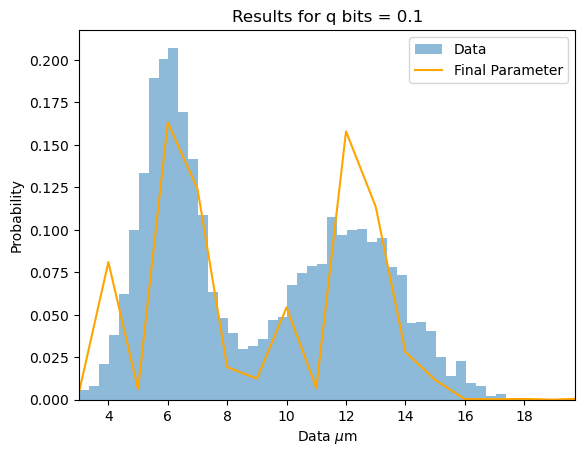

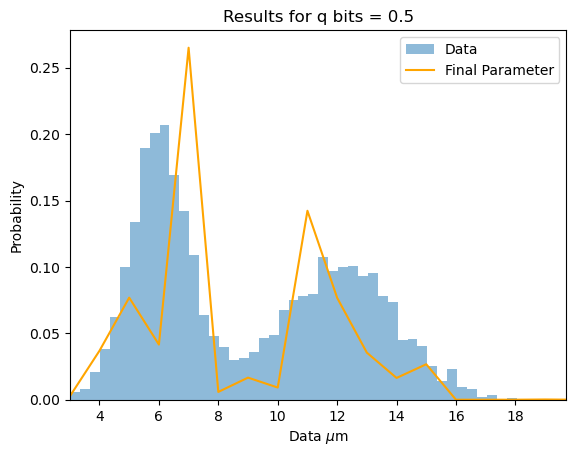

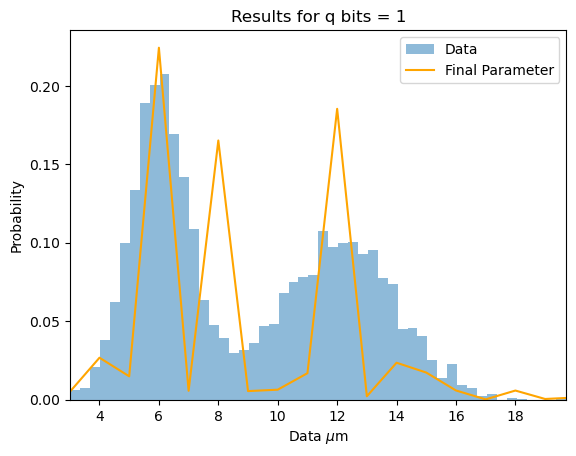

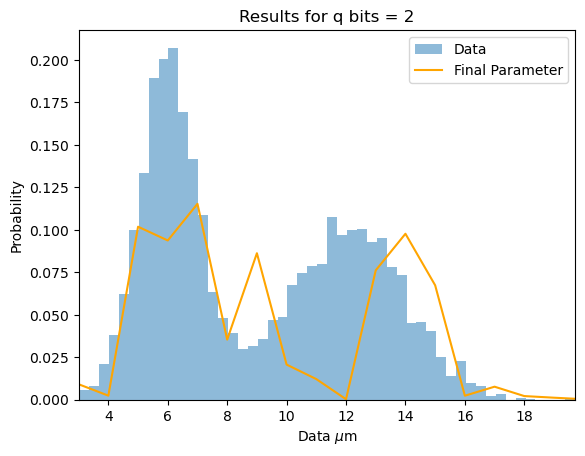

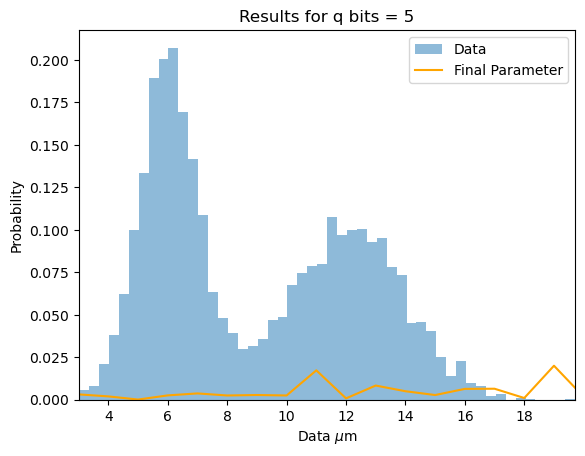

In [26]:
    
# Iterate over the results_beta dictionary and plot each set of results
for qbits, (final_st, cost,time,_) in results_sigmas.items():
    fig = plot_histogram_and_line(data, final_st)
    plt.title(f"Results for q bits = {qbits}")
    plt.show()  


In [ ]:
# Iterate over the results_beta dictionary and plot each set of results
for sig, (final_st, cost,time, _) in results_sigmas.items():
    fig = plot_histogram_and_line(data, final_st)
    plt.title(f"Results for sig = {sig}")
    plt.show()